<a href="https://colab.research.google.com/github/yankikalfa/MGTF-405-Business-Forecasting/blob/main/Canvas_Panel_Forecasting_Monte_Carlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import typing

class SklearnWrapper:
    def __init__(self, transformation: typing.Callable):
        self.transformation = transformation
        self._group_transforms = []
        # Start with -1 and for each group up the pointer by one
        self._pointer = -1

    def _call_with_function(self, df: pd.DataFrame, function: str):
        # If pointer >= len we are making a new apply, reset _pointer
        if self._pointer >= len(self._group_transforms):
            self._pointer = -1
        self._pointer += 1
        return pd.DataFrame(
            getattr(self._group_transforms[self._pointer], function)(df.values),
            columns=df.columns,
            index=df.index,
        )

    def fit(self, df):
        self._group_transforms.append(self.transformation.fit(df.values))
        return self

    def transform(self, df):
        return self._call_with_function(df, "transform")

    def fit_transform(self, df):
        self.fit(df)
        return self.transform(df)



In [ ]:
class custom_split():
    def __init__(self, n_splits=3,max_train_size=None, test_size=None, gap=0):
        self.n_splits = n_splits
        self.max_train_size = max_train_size
        self.test_size = test_size
        self.gap = gap

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features) 
            Training data, where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
        
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        #X, y, groups = indexable(X, y, groups)
        n_samples = X.shape[0]
        n_splits = self.n_splits
        n_folds = n_splits + 1
        gap = self.gap
        test_size = (
            self.test_size if self.test_size is not None else n_samples // n_folds
        )

        # Make sure we have enough samples for the given split parameters
        if n_folds > n_samples:
            raise ValueError(
                f"Cannot have number of folds={n_folds} greater"
                f" than the number of samples={n_samples}."
            )
        if n_samples - gap - (test_size * n_splits) <= 0:
            raise ValueError(
                f"Too many splits={n_splits} for number of samples"
                f"={n_samples} with test_size={test_size} and gap={gap}."
            )

        indices = np.arange(n_samples)
        group_ = X[groups].unique()
        req = group_[-n_splits:]

        for test_start in req:
            train_end = max(X[X[groups]<test_start].index)+1
            test_end = max(X[X[groups]==test_start].index)+1
            yield (
                    indices[: train_end],
                    indices[train_end : test_end],
                )

In [ ]:
scalermin=SklearnWrapper(MinMaxScaler(feature_range=(-1,1)))

In [ ]:
def timeseries_prediction_stdscale(input_data, to_predict, split_column ,cc,columns, cv_model, cv_split, val_size, n_jobs, max_iter=1000, return_alphas = False):
    """
    parameters:
    -----------
    input_data = data_frame of all input variables(X) to build the model
    to_predict = pandas series of output variables to build the model 
    cv_model = number of cross validation splits
    val_size = number of validation samples to predict on after each cross validation step
    start = initial number of input variables to consider
    alpha = regularizer value for model
    max_iter = maximum iterations to run while running the model
    
    returns:
    --------
    rmse_train = Return the train rmse of all the models
    rmse_test = Return the validation rmse of all the models
    r_squared = Return the r squared value of train set of all the models
    predicted_values = The predicted values over time by each model
    """
    scaler =scalermin
    start = cc
    x_new = input_data[input_data[split_column]<=start]
    y_new = to_predict[:x_new.shape[0]]

    cv = custom_split(n_splits = cv_split)
    predicted_values = []
    
    mse_cv = []
    mse_train = []
    mse_test = []
    r_squared = []
    alphas = []
    coef=[]
    x_tr_list=[]
    
    for i in range(start,max(input_data[split_column])):
        
        cv_ = cv.split(x_new,groups = split_column)
        x_new_tr=x_new.drop(['permno', 'dgma'],axis=1).groupby(['fyear','ffi49']).apply(scaler.fit_transform).drop(['fyear','ffi49'],axis=1)
        #x_new_tr = scaler.fit_transform(x_new.drop(['fyear','permno','dgma'],axis=1))

        if cv_model =='Lasso':
            model = LassoCV(cv=cv_,n_jobs=n_jobs,max_iter=max_iter)
            results = model.fit(x_new_tr,y_new)
        elif cv_model =='Elastic Net':
            model = ElasticNetCV(cv=cv_,n_jobs=n_jobs,max_iter=max_iter)
            results = model.fit(x_new_tr,y_new)
        else:
            raise Exception("Please input the cross validation model as Lasso, Ridge or ElasticNet.")
        
        coef.append(results.coef_)
        best_alpha_index = np.where(results.alphas_==results.alpha_)[0][0]
        mse_cv.append(results.mse_path_[best_alpha_index])
        alphas.append(model.alpha_)
        
        prediction_train = results.predict(x_new_tr)        
        start += 1
        prediction_test = results.predict(input_data[input_data[split_column]==start].drop(['permno', 'dgma'],axis=1).groupby(['fyear','ffi49']).apply(scaler.fit_transform).drop(['fyear','ffi49'],axis=1))
        
        r_squared.append(r2_score(y_new, prediction_train))
        mse_train.append(mean_squared_error(y_new, prediction_train))
        #rmse_test.append(np.sqrt(mean_squared_error(to_predict[start], prediction_test)))
        
        x_new = x_new.append(input_data[input_data[split_column]==start])
        y_new = to_predict[:x_new.shape[0]]
        predicted_values = predicted_values + list(prediction_test)
        x_tr_list.append(x_new_tr)
    
    mse_test.append(mean_squared_error(to_predict[input_data[input_data[split_column]<=cc].loc[:,columns].shape[0]:], predicted_values))
    
    if return_alphas:
        return mse_train, mse_test, r_squared, predicted_values, mse_cv,coef, alphas

    else:    
        return mse_train, mse_test, r_squared, predicted_values, mse_cv,coef

    

In [ ]:
lasso_mse_is, lasso_mse_oos, lasso_r2_is, lasso_f, lasso_mse_cv, lasso_coef, lasso_alpha = timeseries_prediction_stdscale(df,Y,'fyear',1990,columns,'Lasso',5,1,-10,max_iter = 1000,return_alphas=True)
enet_mse_is, enet_mse_oos, enet_r2_is, enet_f, enet_mse_cv, enet_coef, enet_alpha = timeseries_prediction_stdscale(df,Y,'fyear',1990,columns,'Elastic Net',5,1,-10,max_iter = 1000,return_alphas=True)

# Monte Carlo

In [ ]:
! pip install linearmodels

In [ ]:
import seaborn as sns
from scipy import stats
from linearmodels import PanelOLS

In [ ]:
list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy',
                 'chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib',
                 'exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm',
                 'genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma',
                 'genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic',
                 'halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu',
                 'kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell',
                 'mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm',
                 'rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm',
                 'tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']

results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(df_34['op'])
    a = stats.kstest(df_34['op'], i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1833: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:3614: RuntimeWarning: divide by zero encountered in double_scalars
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:5320: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:7276: RuntimeWarning: overflow encountered in exp
  return 1.0-_norm_cdf(isqx*trm1)-np.exp(2.0/mu)*_norm_cdf(-isqx*trm2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_continuous_distns.py:7276: RuntimeWarning: invalid value encountered in multiply
  return 1.0-_norm_cdf(isqx*trm1)-np.exp(2.0/mu)*_norm_cdf(-isqx*trm2)
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrast

johnsonsu: statistic=0.017401979312115845, pvalue=0.5903037582319464
nct: statistic=0.018294668118042368, pvalue=0.5256983369021486
recipinvgauss: statistic=nan, pvalue=nan
tukeylambda: statistic=0.020033653283082153, pvalue=0.40924457493203115
hypsecant: statistic=0.021120726127563272, pvalue=0.3447438530580931
t: statistic=0.021630561140839166, pvalue=0.31692691812839746
dgamma: statistic=0.022721734120621728, pvalue=0.2627030857365009
dweibull: statistic=0.02290021138127192, pvalue=0.25451770365412696
burr12: statistic=0.02330418090514441, pvalue=0.23668809900078502
mielke: statistic=0.02550165864771403, pvalue=0.15576461703800804
burr: statistic=0.027353434973322654, pvalue=0.10625456858846616
genlogistic: statistic=0.027439629848091562, pvalue=0.10431076040624043
logistic: statistic=0.027515482108167122, pvalue=0.10262467241080431
fisk: statistic=0.02751650440558584, pvalue=0.10260210364594624
gennorm: statistic=0.02972962570197446, pvalue=0.06252173636750669
laplace: statistic=0.

In [ ]:
dist = getattr(stats, 'johnsonsu')
parameters = dist.fit(None)
print(parameters)

(-0.14152771564165317, 1.413028742318053, 0.11136013719260582, 0.11942597324147033)


In [ ]:
PanelOLS(y-variable,x_set,entity_effects=True,time_effects=True).fit()

Dep. Variable:,op,R-squared:,0.2136
Estimator:,PanelOLS,R-squared (Between):,0.6147
No. Observations:,1684,R-squared (Within):,0.2208
Date:,"Fri, Nov 18 2022",R-squared (Overall):,0.5973
Time:,06:56:09,Log-likelihood,2564.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,383.98
Entities:,265,P-value,0.0000
Avg Obs:,6.3547,Distribution:,"F(1,1414)"
Min Obs:,0.0000,,
Max Obs:,38.000,F-statistic (robust):,383.98


### ARIMA Simulation

In [ ]:
def ARIMA(phi = np.array([0]), theta = np.array([0]), d = 0, t = 0, n = 20, burn = 10):
    """ Simulate data from ARMA model (eq. 1.2.4):

    z_t = phi_1*z_{t-1} + ... + phi_p*z_{t-p} + a_t + theta_1*a_{t-1} + ... + theta_q*a_{t-q}

    with d unit roots for ARIMA model.

    Arguments:
    phi -- array of shape (p,) or (p, 1) containing phi_1, phi2, ... for AR model
    theta -- array of shape (q) or (q, 1) containing theta_1, theta_2, ... for MA model
    d -- number of unit roots for non-stationary time series
    t -- value deterministic linear trend
    mu -- mean value for normal distribution error term
    sigma -- standard deviation for normal distribution error term
    n -- length time series
    burn -- number of discarded values because series beginns without lagged terms

    Return:
    x -- simulated ARMA process of shape (n, 1)

    Reference:
    Time Series Analysis by Box et al.
    """

    # add "theta_0" = 1 to theta
    theta = np.append(1, theta)
    
    # set max lag length AR model
    p = phi.shape[0]

    # set max lag length MA model
    q = theta.shape[0]

    # simulate n + q error terms

    a = stats.johnsonsu(-0.1415,1.413029,0.1114,0.119425).rvs(size=(n + max(p, q) + burn, 1))
    
    # create array for returned values
    x = np.zeros((n + max(p, q) + burn, 1))

    # initialize first time series value
    x[0] = a[0]

    for i in range(1, x.shape[0]):
        AR = np.dot(phi[0 : min(i, p)], np.flip(x[i - min(i, p) : i], 0))
        MA = np.dot(theta[0 : min(i + 1, q)], np.flip(a[i - min(i, q - 1) : i + 1], 0))
        x[i] = AR + MA + t

    # add unit roots
    if d != 0:
        ARMA = x[-n: ]
        m = ARMA.shape[0]
        z = np.zeros((m + 1, 1)) # create temp array

        for i in range(d):
            for j in range(m):
                z[j + 1] = ARMA[j] + z[j] 
            ARMA = z[1: ]
        x[-n: ] = z[1: ]
        
    return pd.DataFrame(x[-n: ])

### Monte Carlo simulation

In [ ]:
list1 = []
def monte_carlo(s):
    for i in range(s):
        np.random.seed(i)
        df = ARIMA(phi = np.array([0.4]), theta = np.array([0]), n = 100,d=0)
        list1.append(df)
    return list1

In [ ]:
a =monte_carlo(1000)

In [ ]:
df_mc=pd.concat(a,axis=1)  

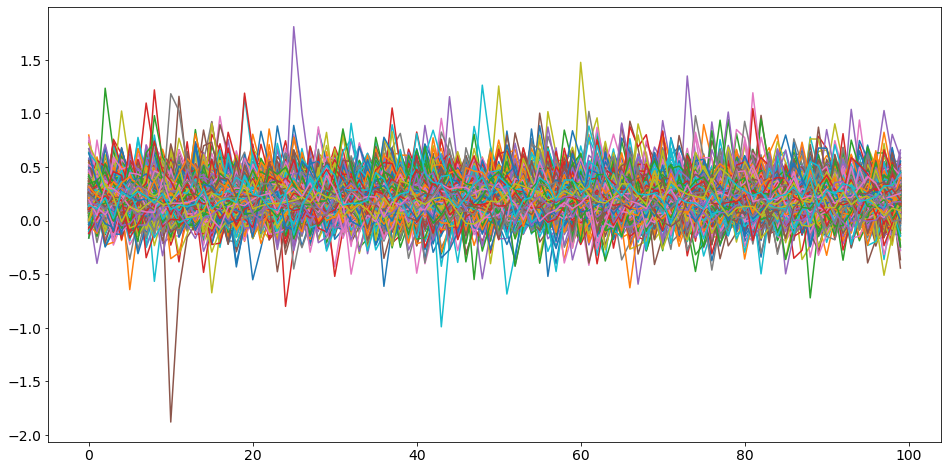

In [ ]:
plt.plot(df_mc);

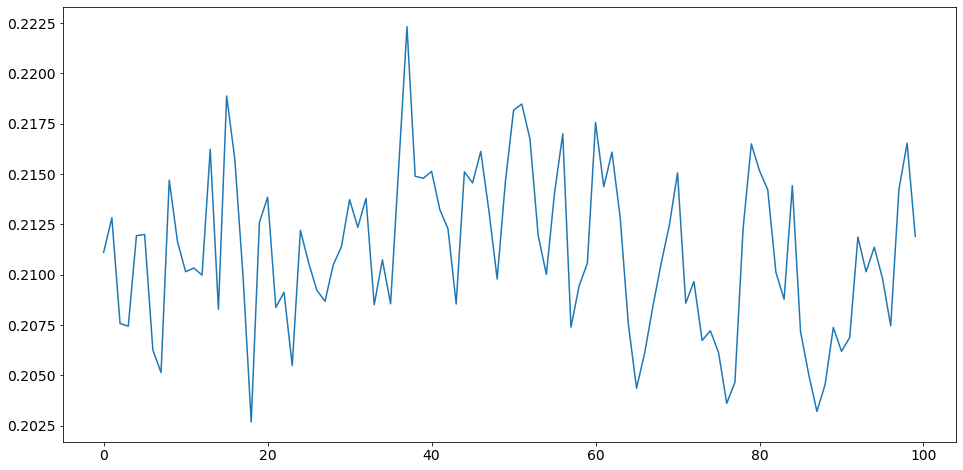

In [ ]:
df_mc.mean(axis=1).plot()